In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import warnings
import math

os.chdir('../..')

/home/leon/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load the PSDs
Normalization is not needed for this method!

In [2]:
loaded = np.load('./Generated/Spectrums/psds_array_fft.npz')

results_arr = []

i = 0
while f'psd_{i}' in loaded:
    psd = loaded[f'psd_{i}']
    s_id = int(loaded[f'subject_id_{i}'])
    t_id = int(loaded[f'trial_id_{i}'])
    gender = str(loaded[f'gender_{i}'])
    handiness = str(loaded[f'handiness_{i}'])
    age = int(loaded[f'age_{i}'])
    
    results_arr.append([psd, s_id, t_id, gender, handiness, age])
    i += 1

psd, s_id, t_id, gender, handiness, age = results_arr[10]
psd.shape

(63, 381)

### Normalize

In [13]:
# Parse into two lists will be used furthere
psds_array = [item[0] for item in results_arr]
psds_array = np.array(psds_array)                            # Convert list of PSDs to a numpy array
psds_array = psds_array.reshape((psds_array.shape[0], -1))   # Vectorize 

print(f"Reshaped to {psds_array.shape} for normalization")

metadata = [item[1:] for item in results_arr]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
psds_array = scaler.fit_transform(psds_array)

psds_array = psds_array.reshape((31, 63, 381))

print(f"Reshaped back to {psds_array.shape}")

results_arr = []
for i in range(psds_array.shape[0]):
    psd = psds_array[i]
    meta = metadata[i]
    results_arr.append([psd] + meta)

psd, s_id, t_id, gender, handiness, age = results_arr[10]
psd.shape

Reshaped to (31, 24003) for normalization
Reshaped back to (31, 63, 381)


(63, 381)

# Calcilate log spectral difference (in db)

18


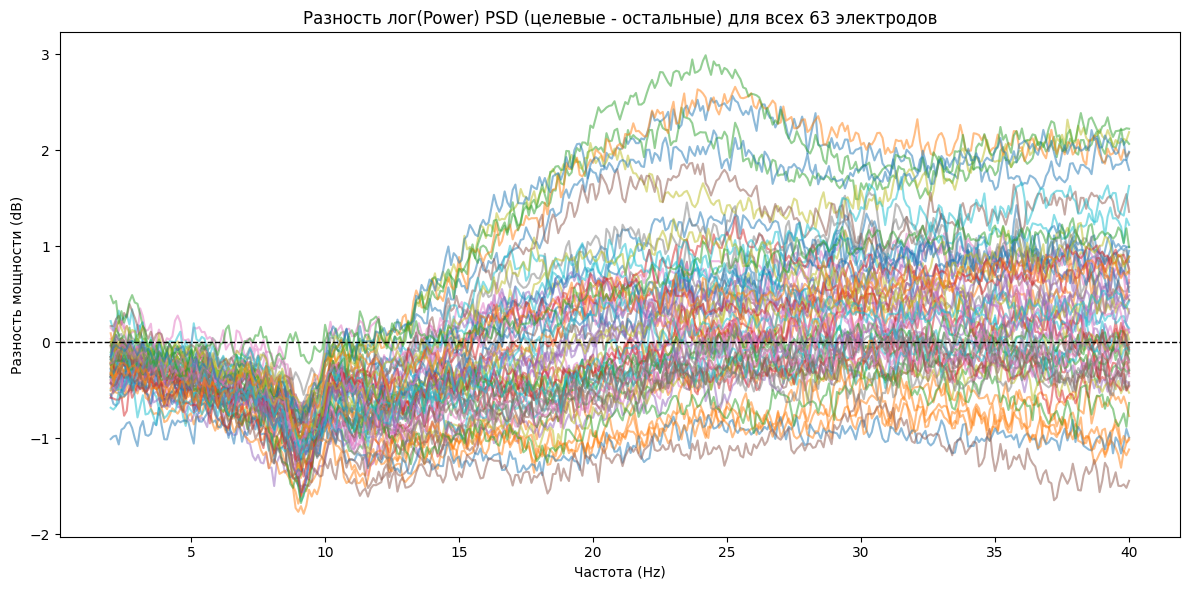

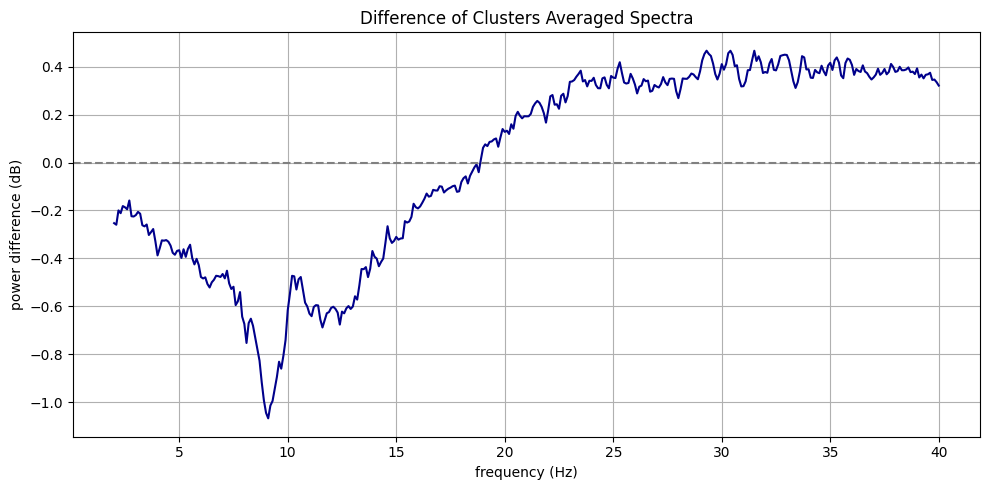

In [28]:
import numpy as np
import matplotlib.pyplot as plt

clust_1 = ['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2', 'S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1']

clust_2 = ['S14_T1', 'S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1', 'S7_T2',
             'S7_T1', 'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
             'S11_T1', 'S9_T2', 'S9_T1', 'S13_T2', 'S13_T1']


clust_1_1 = ['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2']

clust_1_2 = ['S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1']


clust_2_1 = ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1']

clust_2_2 = ['S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
               'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
               'S11_T1', 'S13_T2', 'S13_T1']



# Umap 2 clusters
target_list = clust_2_1

rest_list = clust_2_2

# Umap 1st cluster split by 2
# target_list = ['S15_T1', 'S4_T1', 'S3_T2',
#                'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1']

# rest_list = ['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2']

# Umap 2nd cluster split by 2
# target_list = ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1']

# rest_list = ['S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
#                'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
#                'S11_T1', 'S13_T2', 'S13_T1']

# Разделим на целевые и остальные
target_psds = []
rest_psds = []

print(len(target_list) + len(rest_list))

for psd, s_id, t_id, *_ in results_arr:
    key = f"S{s_id}_T{t_id}"
    if key in target_list:
        target_psds.append(psd)
    elif key in rest_list:
        rest_psds.append(psd)

# В массивы
target_psds = np.array(target_psds)  # (n_target, 63, 381)
rest_psds = np.array(rest_psds)      # (n_rest, 63, 381)

# Логарифмирование перед усреднением (в dB)
target_psds_db = 10 * np.log10(target_psds + 1e-12)
rest_psds_db   = 10 * np.log10(rest_psds + 1e-12)

# Среднее по группам
target_mean_psd = target_psds_db.mean(axis=0)
rest_mean_psd   = rest_psds_db.mean(axis=0)

# z norm
target_mean_psd = (target_mean_psd - target_mean_psd.mean()) / target_mean_psd.std()
rest_mean_psd   = (rest_mean_psd - rest_mean_psd.mean()) / rest_mean_psd.std()

# Разность
diff_psd = target_mean_psd - rest_mean_psd  # (63, 381)

# Частотная ось
freqs = np.linspace(2, 40, diff_psd.shape[1])

# Визуализация
plt.figure(figsize=(12, 6))
for i in range(63):
    plt.plot(freqs, diff_psd[i], alpha=0.5, label=f"Ch {i+1}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Частота (Hz)")
plt.ylabel("Разность мощности (dB)")
plt.title("Разность лог(Power) PSD (целевые - остальные) для всех 63 электродов")
plt.tight_layout()
plt.show()





# В массивы
target_psds = np.array(target_psds)  # (n_target, 63, 381)
rest_psds = np.array(rest_psds)      # (n_rest, 63, 381)

target_psds = 10 * np.log10(target_psds + 1e-12)
rest_psds   = 10 * np.log10(rest_psds + 1e-12)

# Среднее по выборке (по людям)
target_mean = target_psds.mean(axis=0)  # (63, 381)
rest_mean = rest_psds.mean(axis=0)      # (63, 381)

# z norm
target_mean = (target_mean - target_mean.mean()) / target_mean.std()
rest_mean   = (rest_mean - rest_mean.mean()) / rest_mean.std()

# Разность
diff = target_mean - rest_mean  # (63, 381)

# Среднее по каналам → одна кривая
mean_diff = diff.mean(axis=0)  # (381,)

# Частотная ось
freqs = np.linspace(2, 40, mean_diff.shape[0])

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(freqs, mean_diff, color='darkblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Difference of Clusters Averaged Spectra")
plt.xlabel("frequency (Hz)")
plt.ylabel("power difference (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

4 records.


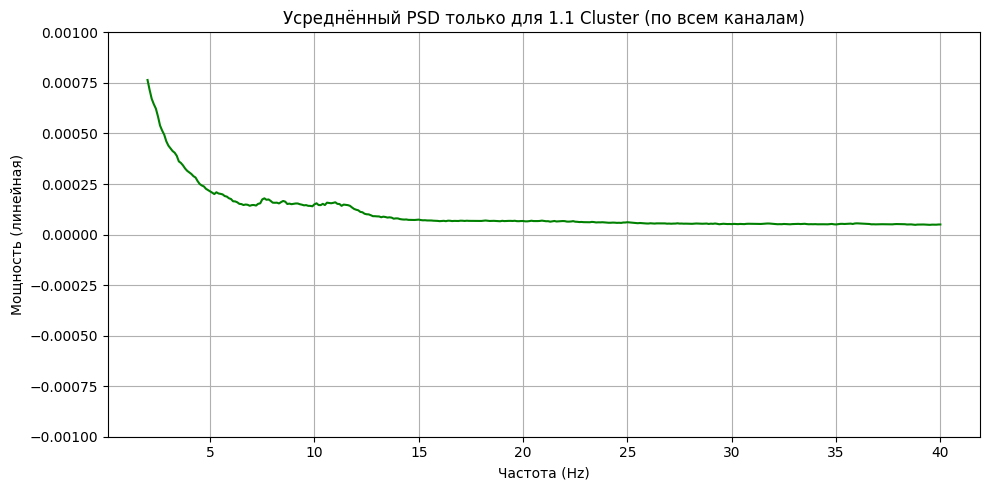

9 records.


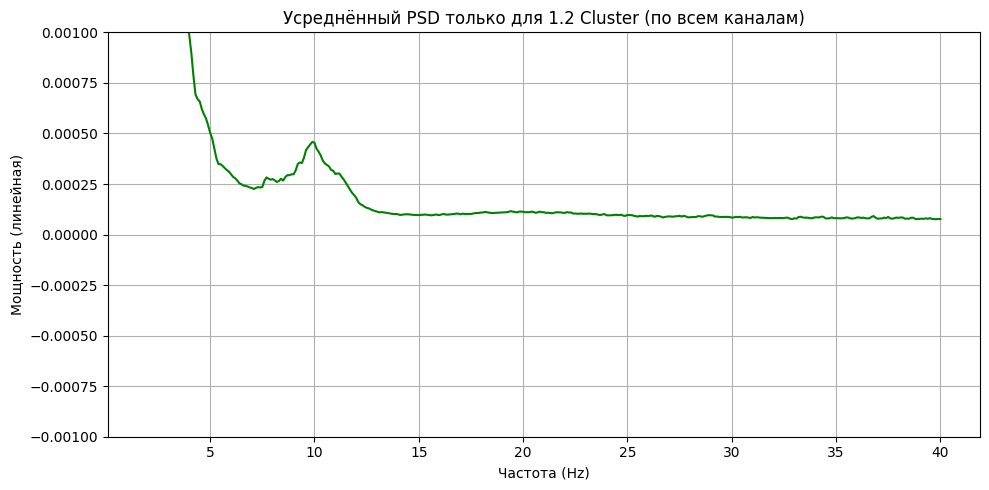

5 records.


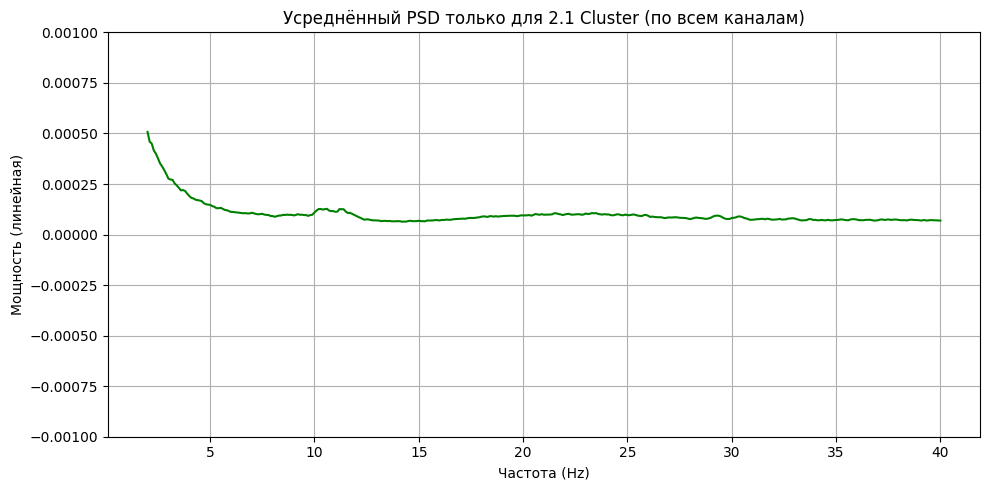

13 records.


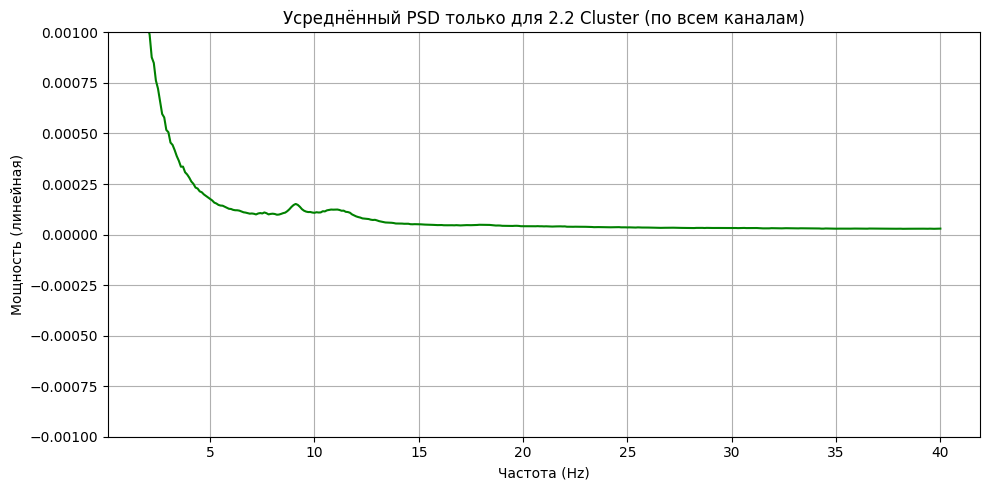

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Пример target_list
target_lists = [['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2'], 
                
               ['S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1'], 
                
               ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1'],
                
               ['S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
               'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
               'S11_T1', 'S13_T2', 'S13_T1']]

clust_names = ['1.1', '1.2', '2.1', '2.2']

for target_list, clust_name in zip(target_lists, clust_names):
    # Сбор только целевых PSD
    target_psds = []
    
    for psd, s_id, t_id, *_ in results_arr:
        key = f"S{s_id}_T{t_id}"
        if key in target_list:
            target_psds.append(psd)
    
    # Проверка
    if not target_psds:
        raise ValueError("Ни один элемент из target_list не найден в results_arr.")
    print(f"{len(target_psds)} records.")
    
    # В массив и усреднение
    target_psds = np.array(target_psds)       # (n_target, 63, 381)
    # target_psds = 10 * np.log10(target_psds + 1e-12)
    mean_psd = target_psds.mean(axis=(0, 1))  # усреднение по людям и каналам → (381,)
    
    # Частотная ось
    freqs = np.linspace(2, 40, mean_psd.shape[0])
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_psd, color='green')
    plt.title(f"Усреднённый PSD только для {clust_name} Cluster (по всем каналам)")
    plt.ylim((-0.001, 0.001))
    plt.xlabel("Частота (Hz)")
    plt.ylabel("Мощность (линейная)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


13 records.


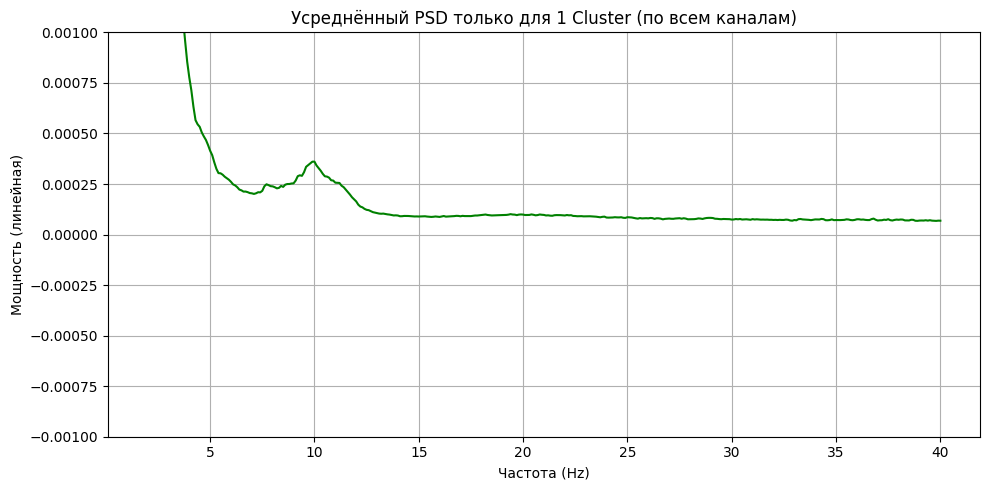

18 records.


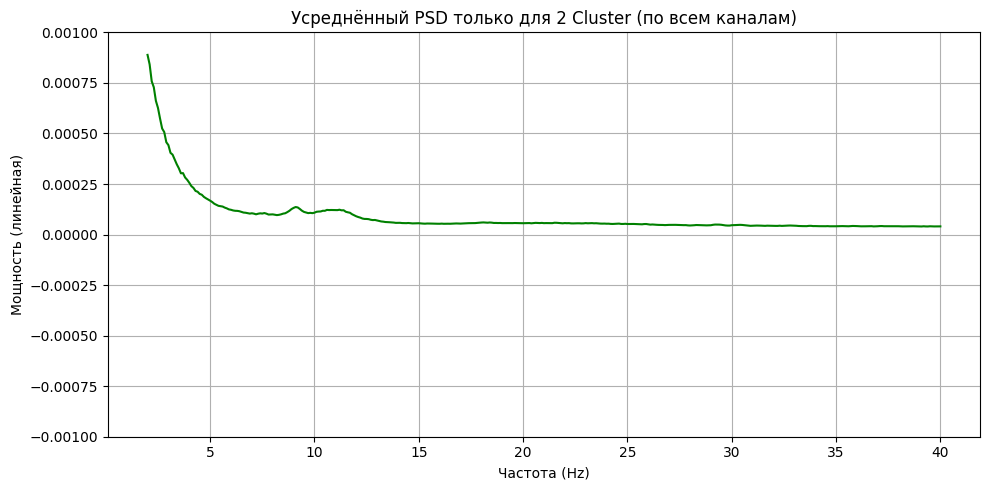

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Пример target_list
target_lists = [['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2', 
               'S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1'], 
                
               ['S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1',
                'S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
               'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
               'S11_T1', 'S13_T2', 'S13_T1']]

clust_names = ['1', '2']

for target_list, clust_name in zip(target_lists, clust_names):
    # Сбор только целевых PSD
    target_psds = []
    
    for psd, s_id, t_id, *_ in results_arr:
        key = f"S{s_id}_T{t_id}"
        if key in target_list:
            target_psds.append(psd)
    
    # Проверка
    if not target_psds:
        raise ValueError("Ни один элемент из target_list не найден в results_arr.")
    print(f"{len(target_psds)} records.")
    
    # В массив и усреднение
    target_psds = np.array(target_psds)       # (n_target, 63, 381)
    # target_psds = 10 * np.log10(target_psds + 1e-12)
    mean_psd = target_psds.mean(axis=(0, 1))  # усреднение по людям и каналам → (381,)
    
    # Частотная ось
    freqs = np.linspace(2, 40, mean_psd.shape[0])
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_psd, color='green')
    plt.title(f"Усреднённый PSD только для {clust_name} Cluster (по всем каналам)")
    plt.ylim((-0.001, 0.001))
    plt.xlabel("Частота (Hz)")
    plt.ylabel("Мощность (линейная)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

29 records.


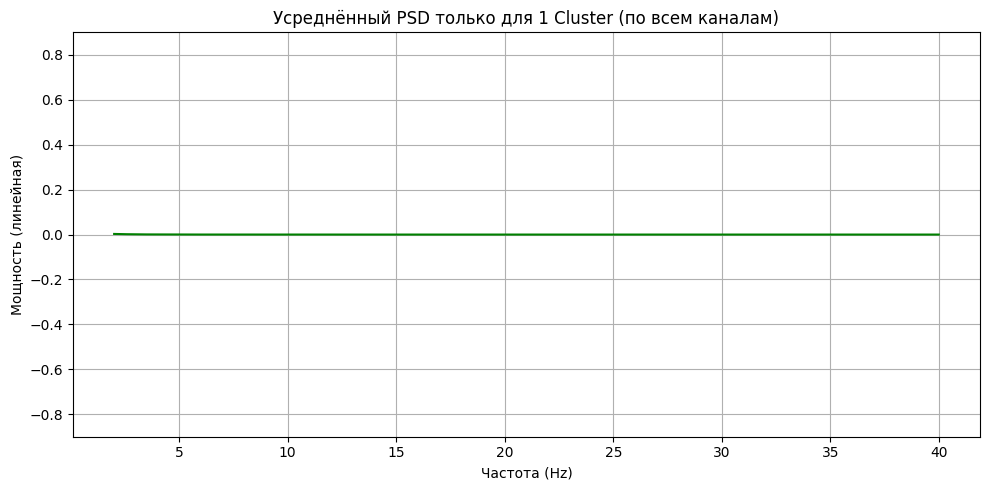

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Пример target_list
target_lists = [['S11_T2', 'S4_T2', 'S8_T1', 'S15_T2', 
               'S15_T1', 'S4_T1', 'S3_T2',
               'S10_T2', 'S1_T2', 'S8_T2', 'S6_T2', 'S1_T1', 'S6_T1' 
                
               'S7_T2', 'S7_T1', 'S9_T2', 'S9_T1', 'S14_T1',
                'S5_T2', 'S5_T1', 'S3_T1', 'S2_T2', 'S2_T1',
               'S10_T1', 'S12_T2', 'S12_T1', 'S16_T2', 'S16_T1',
               'S11_T1', 'S13_T2', 'S13_T1']]

clust_names = ['1', '2']

for target_list, clust_name in zip(target_lists, clust_names):
    # Сбор только целевых PSD
    target_psds = []
    
    for psd, s_id, t_id, *_ in results_arr:
        key = f"S{s_id}_T{t_id}"
        if key in target_list:
            target_psds.append(psd)
    
    # Проверка
    if not target_psds:
        raise ValueError("Ни один элемент из target_list не найден в results_arr.")
    print(f"{len(target_psds)} records.")
    
    # В массив и усреднение
    target_psds = np.array(target_psds)       # (n_target, 63, 381)
    # target_psds = 10 * np.log10(target_psds + 1e-12)
    mean_psd = target_psds.mean(axis=(0, 1))  # усреднение по людям и каналам → (381,)
    
    # Частотная ось
    freqs = np.linspace(2, 40, mean_psd.shape[0])
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, mean_psd, color='green')
    plt.title(f"Усреднённый PSD только для {clust_name} Cluster (по всем каналам)")
    plt.xlabel("Частота (Hz)")
    plt.ylim((-0.9, 0.9))
    plt.ylabel("Мощность (линейная)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()